## CNN classifier for multi label tagging of Myntra fashion products

In [192]:
import numpy as np
import pandas as pd
import os
import PIL
import keras

from keras.preprocessing.image import load_img, img_to_array


In [ ]:
!git clone https://github.com/sharathrjtr/CNN_model_fashion_products_multi_label_tagging.git

In [ ]:
# import kaggle
# os.environ['KAGGLE_USERNAME'] = "sharathrjtr"
# os.environ['KAGGLE_KEY'] = ""#"d35c14881c49c76dfc844f0740236ad1"
# upload your kaggle.json file. If you don't have it then you can get it by clicking "Create New API Token" under your kaggle Account/Profile/API
os.environ['KAGGLE_CONFIG_DIR']='/content/'
!kaggle datasets download -d paramaggarwal/fashion-product-images-small
# !rm -r fashion-product-images-small.zip

In [128]:
def cleanup_csv_mapping(mapping_csv):
    # articleType can be used to find subCategory and masterCategory. 
    # Year specifies particular year the product is made, productDisplayName is something unique to the product and not a generalization.
    # Hence, we are dropping masterCategory, subCartegory, year and productDisplayName columns from the data frame.
    mapping_csv.drop(['masterCategory', 'subCategory', 'year', 'productDisplayName'], axis=1, inplace=True)

    # Drop the samples which don't have any value in any of the columns.
    mapping_csv.dropna(inplace=True)
    mapping_csv.head()
    
    return mapping_csv

In [154]:
# create a list of tags available among gender, articleType, baseColour, season and usage
# generate a mapping from tags to integers and integers to tags
def extract_tags_mapping(mapping_csv):
    labels = set()
    
    for index, row in mapping_csv.iterrows():
        fileid = row['id']
        gender = row['gender']
        article_type = row['articleType']
        base_colour = row['baseColour']
        season = row['season']
        usage = row['usage']
        
        labels.update([gender, article_type, base_colour, season, usage])
    print('Total labels:', len(labels))

    # convert the labels to a list and sort them alphabetically
    labels = list(labels)
    # order set alphabetically
    labels.sort()
    
    # create dictionary that maps labels to integers so that we can encode the training dataset for modeling.
    # create a dictionary with reverse mapping from integers to string tag values, so later when the model makes a prediction, we can turn it into something readable.
    labels_map = {labels[i]: i for i in range(len(labels))}
    inv_labels_map = {i:labels[i] for i in range(len(labels))}
    
    return labels_map, inv_labels_map

In [149]:
# extract the training images filename and labels for all images.
def extract_img_ids_labels(mapping_csv):
    image_ids = []
    image_labels = dict()
    for index, row in mapping_csv.iterrows():
        fileid = row['id']
        gender = row['gender']
        article_type = row['articleType']
        base_colour = row['baseColour']
        season = row['season']
        usage = row['usage']
        
        if os.path.exists('myntradataset/images/'+str(fileid)+'.jpg'):
            image_ids.append(fileid)
            image_labels[fileid] = [gender, article_type, base_colour, season, usage]
    
    print('Number of train files: ', len(image_ids))
    
    return image_ids, image_labels

In [131]:
# create a one hot encoding for one list of tags
def one_hot_encode(tags, mapping):
    # create empty vector
    encoding = np.zeros(len(mapping), dtype='uint8')
    # mark 1 for each tag in the vector
    for tag in tags:
        encoding[mapping[tag]] = 1
    return encoding

In [146]:
# load images and extract labels in one hot encode form
def load_dataset(image_ids, image_labels, tag_mapping):
    images, targets = list(), list()
    # enumerate file in the directory
    for filename in image_ids:
        # load image
        image = load_img(os.path.join('myntradataset/images', str(filename)+'.jpg'), target_size=(60,80))
        # convert to numpy array
        image = img_to_array(image, dtype='uint8')
        # get tags
        tags = image_labels[filename]
        # one hot encode tags
        target = one_hot_encode(tags, tag_mapping)
        # store train image and tags
        images.append(image)
        targets.append(target)
    
    X = np.asarray(images, dtype='uint8')
    y = np.asarray(targets, dtype='uint8')
    return X, y

In [137]:
csv_filename = 'myntradataset/styles.csv'
# Read the csv file and clean up the file to extract relevant data
# productDisplayName column consist of extra commas for few row. 
# These were manually removed as it can result in error during reading of the file
mapping_csv = pd.read_csv(filename)
print(mapping_csv.shape)

mapping_csv = cleanup_csv_mapping(mapping_csv)
print(mapping_csv.shape)
mapping_csv.head()

(44446, 10)
(44101, 6)


,id,gender,articleType,baseColour,season,usage
0,15970,Men,Shirts,Navy Blue,Fall,Casual
1,39386,Men,Jeans,Blue,Summer,Casual
2,59263,Women,Watches,Silver,Winter,Casual
3,21379,Men,Track Pants,Black,Fall,Casual
4,53759,Men,Tshirts,Grey,Summer,Casual


In [155]:
# extract mapping from labels to indices and indices to labels
labels_to_idx, idx_to_labels = extract_tags_mapping(mapping_csv)

# extract the images filename and tags for training dataset
train_ids, train_labels = extract_img_ids_labels(mapping_csv)

# load the dataset, the actual images and labels for each image with one-hot encoding
train_images, train_tags = load_dataset(train_ids, train_labels, labels_to_idx)
print(train_images.shape, train_tags.shape)

# Total size of image loaded will be about 60*80*3*44101*8 / (1000000000*8) = 0.635GB
# save both arrays to one file in compressed format
np.savez_compressed('myntra_train_data.npz', train_images, train_tags)

Total labels: 205
Number of train files:  44096
(44096, 60, 80, 3) (44096, 205)


In [193]:
# baseline model for the planet dataset
import sys
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score

import keras
from keras.applications.vgg16 import VGG16
from keras import backend
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD

In [194]:
def load_saved_dataset():
    data = np.load('myntra_train_data.npz')
    X, y = data['arr_0'], data['arr_1']
    trainX, testX, trainY, testY = train_test_split(X, y, test_size = 0.3, random_state = 1)
    print(trainX.shape, trainY.shape, testX.shape, testY.shape)
    
    return trainX, trainY, testX, testY

In [195]:
 # calculate fbeta score for multi-class/label classification
def fbeta(y_true, y_pred, beta=2):
    # clip predictions
    y_pred = keras.backend.clip(y_pred, 0, 1)
    # calculate elements
    tp = keras.backend.sum(keras.backend.round(keras.backend.clip(y_true * y_pred, 0, 1)), axis=1)
    fp = keras.backend.sum(keras.backend.round(keras.backend.clip(y_pred - y_true, 0, 1)), axis=1)
    fn = keras.backend.sum(keras.backend.round(keras.backend.clip(y_true - y_pred, 0, 1)), axis=1)
    # calculate precision
    p = tp / (tp + fp + keras.backend.epsilon())
    # calculate recall
    r = tp / (tp + fn + keras.backend.epsilon())
    # calculate fbeta, averaged across each class
    bb = beta ** 2
    fbeta_score = keras.backend.mean((1 + bb) * (p * r) / (bb * p + r + keras.backend.epsilon()))
    return fbeta_score

In [196]:

trainX, trainY, testX, testY = load_saved_dataset()

# make all one predictions
train_yhat = np.asarray([np.ones(trainY.shape[1]) for _ in range(trainY.shape[0])])
test_yhat = np.asarray([np.ones(testY.shape[1]) for _ in range(testY.shape[0])])
# evaluate predictions
train_score = fbeta_score(trainY, train_yhat, 2, average='samples')
test_score = fbeta_score(testY, test_yhat, 2, average='samples')
print('All Ones: train=%.3f, test=%.3f' % (train_score, test_score))

# evaluate predictions with keras
train_score = fbeta(keras.backend.variable(trainY), keras.backend.variable(train_yhat))
test_score = fbeta(keras.backend.variable(testY), keras.backend.variable(test_yhat))

print('All Ones (keras): train=%.3f, test=%.3f' % (keras.backend.eval(train_score), keras.backend.eval(test_score)))

(30867, 60, 80, 3) (30867, 205) (13229, 60, 80, 3) (13229, 205)
All Ones: train=0.111, test=0.111
All Ones (keras): train=0.111, test=0.111


In [198]:
# define cnn model
def define_baseline_model(in_shape=(60,80, 3), out_shape=205):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=in_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(out_shape, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])
    return model

In [200]:
# plot diagnostic learning curves
def summarize_diagnostics(history, figname):
    # plot loss
#     pyplot.subplot(211)
#     pyplot.figure()
    
    pyplot.plot(history.history['loss'], color='blue', label='train_loss')
    pyplot.plot(history.history['val_loss'], color='orange', label='test_loss')
    
    # plot accuracy
#     pyplot.subplot(212)
#     pyplot.title('Fbeta')
    pyplot.plot(history.history['fbeta'], color='blue', label='train_fbeta_score')
    pyplot.plot(history.history['val_fbeta'], color='orange', label='test_fbeta_score')
    
    pyplot.title(figname+': Cross Entropy Loss and Fbeta Score')
    pyplot.legend()
    pyplot.xlabel('Epochs')
    
    # save plot to file
    filename = sys.argv[0].split('/')[-1] + '_' + figname
    pyplot.savefig(filename + '_plot.png')
    pyplot.close()

In [201]:
# run the test harness for evaluating a model
def run_test_harness(model, figname, epochs, height_shift_range=0.0, width_shift_range=0.0, shear_range=0.0, hor_flip=False, vert_flip=False, rot_range=0, featurewise_center=False):
    # load dataset
    trainX, trainY, testX, testY = load_saved_dataset()
    # create data generator
    if featurewise_center:
        datagen = ImageDataGenerator(featurewise_center = True, height_shift_range=height_shift_range, width_shift_range=width_shift_range, shear_range=shear_range, horizontal_flip=hor_flip, vertical_flip=vert_flip, rotation_range=rot_range)
        # specify imagenet mean values for centering
        datagen.mean = [123.68, 116.779, 103.939]
    else:
        datagen = ImageDataGenerator(rescale=1.0/255.0, height_shift_range=height_shift_range, width_shift_range=width_shift_range, shear_range=shear_range, horizontal_flip=hor_flip, vertical_flip=vert_flip, rotation_range=rot_range)
    # prepare iterators
    train_it = datagen.flow(trainX, trainY, batch_size=128)
    test_it = datagen.flow(testX, testY, batch_size=128)
    
    # fit model
    history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
        validation_data=test_it, validation_steps=len(test_it), epochs=epochs, verbose=1)
    # evaluate model
    loss, fbeta = model.evaluate_generator(test_it, steps=len(test_it), verbose=1)
    print('> loss=%.3f, fbeta=%.3f' % (loss, fbeta))
    # learning curves
    summarize_diagnostics(history, figname)

In [202]:
# entry point, run the test harness
model = define_baseline_model()
run_test_harness(model, 'Baseline', 50)

(30867, 60, 80, 3) (30867, 205) (13229, 60, 80, 3) (13229, 205)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
242/242 [==============================] - 47s 192ms/step - loss: 0.1202 - fbeta: 0.2573 - val_loss: 0.0650 - val_fbeta: 0.2117
Epoch 2/50
242/242 [==============================] - 35s 144ms/step - loss: 0.0640 - fbeta: 0.2862 - val_loss: 0.0633 - val_fbeta: 0.3043
Epoch 3/50
242/242 [==============================] - 35s 144ms/step - loss: 0.0621 - fbeta: 0.3286 - val_loss: 0.0614 - val_fbeta: 0.3866
Epoch 4/50
242/242 [==============================] - 35s 145ms/step - loss: 0.0599 - fbeta: 0.3629 - val_loss: 0.0593 - val_fbeta: 0.3886
Epoch 5/50
242/242 [==============================] - 36s 148ms/step - loss: 0.0576 - fbeta: 0.3926 - val_loss: 0.0572 - val_fbeta: 0.4360
Epoch 6/50
242/242 [==============================] - 36s 149ms/step - loss: 0.0553 - fbeta: 0.4218 - val_loss: 0.0546 - val_fbeta: 0.4172


Epoch 45/50
242/242 [==============================] - 35s 143ms/step - loss: 0.0322 - fbeta: 0.6906 - val_loss: 0.0343 - val_fbeta: 0.6696
Epoch 46/50
242/242 [==============================] - 35s 144ms/step - loss: 0.0319 - fbeta: 0.6919 - val_loss: 0.0340 - val_fbeta: 0.6697
Epoch 47/50
242/242 [==============================] - 35s 144ms/step - loss: 0.0318 - fbeta: 0.6941 - val_loss: 0.0347 - val_fbeta: 0.6442
Epoch 48/50
242/242 [==============================] - 35s 144ms/step - loss: 0.0315 - fbeta: 0.6984 - val_loss: 0.0339 - val_fbeta: 0.6803
Epoch 49/50
242/242 [==============================] - 35s 144ms/step - loss: 0.0312 - fbeta: 0.7002 - val_loss: 0.0338 - val_fbeta: 0.6721
Epoch 50/50
104/104 [==============================] - 5s 45ms/step
> loss=0.034, fbeta=0.687


In [ ]:
# define cnn model
def define_bl_dropout_model(in_shape=(60, 80, 3), out_shape=205):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=in_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(out_shape, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])
    return model

In [ ]:
# entry point, run the test harness for dropout model without augmentation
model = define_bl_dropout_model()
run_test_harness(model, 'Bl_Dropout', 200)

In [ ]:
# entry point, run the test harness for baseline model with augmentation
model = define_baseline_model()
run_test_harness(model, 'Bl_Img_Aug', 200, 0.1, 0.1, 10, True, True, 90)

In [ ]:
# define cnn model
def define_vgg_model(in_shape=(60, 80, 3), out_shape=205, model_trainable=False):
    # load model
    model = VGG16(include_top=False, input_shape=in_shape)
    # mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable = False
    if model_trainable:
        # allow last vgg block to be trainable
        model.get_layer('block5_conv1').trainable = True
        model.get_layer('block5_conv2').trainable = True
        model.get_layer('block5_conv3').trainable = True
        model.get_layer('block5_pool').trainable = True
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
    output = Dense(out_shape, activation='sigmoid')(class1)
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    # compile model
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])
    return model

In [ ]:
# entry point, run the test harness for vgg model without augmentation
model = define_vgg_model()
run_test_harness(model, 'VGG', epochs=20, featurewise_center = True)

In [ ]:
# entry point, run the test harness for baseline model with augmentation
model = define_vgg_model()
run_test_harness(model, 'VGG_fine_tune', 50, featurewise_center = True)

In [ ]:
# entry point, run the test harness for baseline model with augmentation
model = define_vgg_model()
run_test_harness(model, 'VGG_Img_Aug_fine_tune', 50, 0.1, 0.1, 10, True, True, 90, featurewise_center = True)

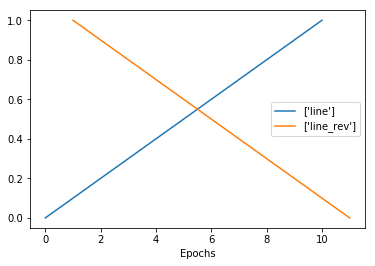

In [217]:
l=np.linspace(0,1,11)
# fig,ax=pyplot.figure(figsize=(6,4))
pyplot.figure()
pyplot.plot(range(11), l, label=['line'])
pyplot.plot(range(11,0,-1), l, label=['line_rev'])
pyplot.xlabel('Epochs')
pyplot.legend()
# pyplot.close()